# Cognitive Age Prediction with MRI and MEG

What else to do:

* run experiments so we will have the same subjects for MEG and MRI
* run profiling to get what takes most of the memory
* do stacking of fMRI and MEG, MRI and MEG as well, to check how they will behave together
* David will provide new MEG features based Rieman geometry and it should improve the performance

In [1]:
import dill
import pandas as pd
import mne
import numpy as np

from camcan.utils import (run_stacking, run_ridge, plot_pred, plot_learning_curve, plot_boxplot,
                          plot_barchart, plot_error_scatters, plot_error_age, plot_error_segments,
                          run_meg_ridge)

%matplotlib inline

/storage/tompouce/okozynet/miniconda3/envs/mne/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


In [2]:
CV = 10
N_JOBS = -1
# store mae, std for the summary plot
anatomy_mae = {}
function_mae = {}
meg_mae = {}
multimodal_mae = {}

anatomy_mae_std = {}
function_mae_std = {}
meg_mae_std = {}
multimodal_mae_std = {}

## Read Data

In [3]:
# read information about subjects
subjects_data = pd.read_csv('../../data/participant_data.csv', index_col=0)
# for storing predictors data
subjects_predictions = pd.DataFrame(subjects_data.age, index=subjects_data.index, dtype=float)

subjects_data.head()

,age,hand,gender_text,gender_code,tiv_cubicmm,cbuid700,cbuid280_sess1,cbuid280_sess2,cbuid280_sess3,cbuid280_sess4,profilecode,profilecode_numeric
Observations,,,,,,,,,,,,
CC110033,24,90.0,MALE,1,1413746.0,CBU120746,NaN,NaN,NaN,NaN,NaN,NaN
CC110037,18,89.0,MALE,1,1386581.0,CBU110544,NaN,NaN,NaN,NaN,NaN,NaN
CC110045,24,100.0,FEMALE,2,1385355.0,CBU111116,NaN,NaN,NaN,NaN,NaN,NaN
CC110056,22,100.0,FEMALE,2,1286849.0,CBU110547,NaN,CBU140153,CBU140224,NaN,D,1.0
CC110062,20,58.0,MALE,1,1582719.0,CBU110468,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# 643 subjects, each covariance is 9x306x306
meg_data = mne.externals.h5io.read_hdf5('../../data/covs_allch_oas.h5')
meg_subjects = {d['subject'] for d in meg_data if 'subject' in d}

print(f'Found {len(meg_data)} subjects')
print(f'A covarince matrix shape is {meg_data[0]["covs"].shape}')

Found 643 subjects
A covarince matrix shape is (9, 306, 306)


In [5]:
# read features

area_data = pd.read_hdf('../../data/structural/structural_data.h5', 
                           key='area')
thickness_data = pd.read_hdf('../../data/structural/structural_data.h5',
                               key='thickness')
volume_data = pd.read_hdf('../../data/structural/structural_data.h5',
                            key='volume')

area_data = area_data.dropna()
thickness_data = thickness_data.dropna()
volume_data = volume_data.dropna()

# take only subjects that are both in MEG and Structural MRI
structural_subjects = set(area_data.index)
common_subjects = meg_subjects.intersection(structural_subjects)

area_data = area_data.loc[common_subjects]
thickness_data = thickness_data.loc[common_subjects]
volume_data = volume_data.loc[common_subjects]

volume_data.head()

,Left-Lateral-Ventricle,Left-Inf-Lat-Vent,Left-Cerebellum-White-Matter,Left-Cerebellum-Cortex,Left-Thalamus-Proper,Left-Caudate,Left-Putamen,Left-Pallidum,3rd-Ventricle,4th-Ventricle,...,SupraTentorialVol,SupraTentorialVolNotVent,SupraTentorialVolNotVentVox,MaskVol,BrainSegVol-to-eTIV,MaskVol-to-eTIV,lhSurfaceHoles,rhSurfaceHoles,SurfaceHoles,EstimatedTotalIntraCranialVol
Measure:volume,,,,,,,,,,,,,,,,,,,,,
CC220901,13794.4,312.8,13896.4,57962.9,7752.1,3097.0,4318.1,2018.2,1006.7,1832.5,...,1.098106e+06,1.063836e+06,1062651.0,1719380.0,0.724914,1.002308,29.0,32.0,61.0,1.715421e+06
CC110033,6018.2,145.2,13938.6,56055.7,8523.9,3604.6,4557.6,2008.8,971.2,1426.7,...,1.030259e+06,1.014403e+06,1011785.0,1596489.0,0.757157,1.029559,41.0,23.0,64.0,1.550654e+06
CC410086,6494.5,179.9,15445.7,58225.7,8073.9,3838.7,4590.7,2340.0,1105.4,1867.4,...,1.063127e+06,1.050664e+06,1048168.0,1657240.0,0.745732,1.017941,22.0,28.0,50.0,1.628032e+06
CC620518,23309.6,829.6,13157.2,52703.8,6409.5,3584.5,4261.5,1994.2,2070.0,1857.5,...,9.677362e+05,9.140572e+05,912201.0,1602950.0,0.685487,0.994806,37.0,43.0,80.0,1.611319e+06
CC610288,34727.5,1561.6,15143.2,58890.2,7253.6,3221.1,4062.4,1993.3,2426.8,2395.5,...,1.034037e+06,9.710127e+05,968246.0,1701787.0,0.694382,0.995423,17.0,11.0,28.0,1.709612e+06


In [6]:
# read connectivity data
connect_data_tangent_basc = pd.read_hdf('../../data/connectivity/connect_data_tangent.h5',
                              key='basc197')
connect_data_r2z_basc = pd.read_hdf('../../data/connectivity/connect_data_correlation.h5',
                              key='basc197')
connect_data_tangent_modl = pd.read_hdf('../../data/connectivity/connect_data_tangent.h5',
                              key='modl256')
connect_data_r2z_modl = pd.read_hdf('../../data/connectivity/connect_data_correlation.h5',
                              key='modl256')
# use only common subjects
connect_data_tangent_basc = connect_data_tangent_basc.loc[common_subjects]
connect_data_r2z_basc = connect_data_r2z_basc.loc[common_subjects]
connect_data_tangent_modl = connect_data_tangent_modl.loc[common_subjects]
connect_data_r2z_modl = connect_data_r2z_modl.loc[common_subjects]

connect_data_tangent_basc.head()

,0,1,2,3,4,5,6,7,8,9,...,19493,19494,19495,19496,19497,19498,19499,19500,19501,19502
CC220901,-0.293135,0.132048,-0.044067,-0.078982,-0.068386,-0.265318,-0.025302,0.032341,-0.136687,-0.234431,...,-0.075908,-0.104971,0.029845,-0.017917,0.127497,0.035326,0.070348,-0.051816,-0.006610,-0.425908
CC110033,0.096697,-0.140008,0.067199,-0.013200,0.040234,-0.163020,-0.029214,0.156358,0.078821,0.087680,...,-0.037457,0.044814,0.021185,-0.036576,-0.054100,-0.002762,0.053630,0.022528,-0.006503,0.273724
CC410086,-0.094554,-0.045534,0.235393,-0.032513,0.032742,0.434684,0.048946,-0.114362,0.067017,0.162662,...,0.006239,-0.097971,0.092576,-0.062865,-0.043497,0.027599,-0.099277,-0.080807,0.145204,0.211516
CC620518,0.491010,0.067577,0.563005,-0.031358,0.000186,0.132394,-0.045795,-0.006669,0.018431,0.419442,...,-0.049718,0.036020,0.009769,0.032463,0.019767,0.027010,-0.035909,0.000654,-0.003319,0.514567
CC610288,-0.112048,-0.069176,-0.004766,0.050723,0.157944,-0.079108,0.046002,0.075107,0.095550,-0.132908,...,-0.000849,0.043685,-0.021838,0.011076,0.039102,-0.026762,0.044790,0.041837,0.013055,-0.024498


## Structural MRI

### Training and Prediction

#### Area

MAE: 10.38
MAE STD: 0.56


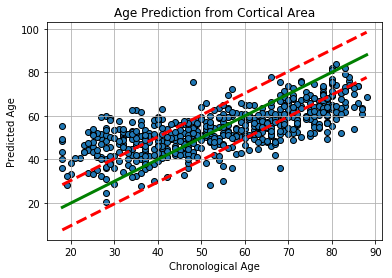

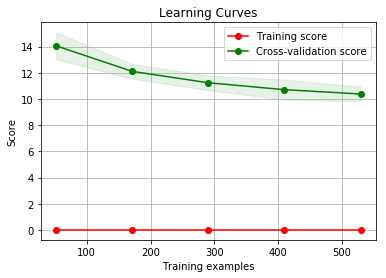

In [7]:
df_pred, arr_mae, arr_r2, train_sizes, train_scores, test_scores = \
    run_ridge(area_data, subjects_data, cv=CV, n_jobs=N_JOBS)

arr_mae = -arr_mae
mae = arr_mae.mean()
std = arr_mae.std()

print('MAE: %.2f' % mae)
print('MAE STD: %.2f' % std)

anatomy_mae['Cortical Surface Area'] = arr_mae
anatomy_mae_std['Cortical Surface Area'] = (mae, std)
subjects_predictions.loc[df_pred.index, 'Cortical Surface Area'] = df_pred[0]

plot_pred(subjects_predictions.loc[df_pred.index].age,
          subjects_predictions.loc[df_pred.index, 'Cortical Surface Area'],
          mae, title='Age Prediction from Cortical Area')
plot_learning_curve(train_sizes, train_scores, test_scores)

#### Thickness

MAE: 7.09
MAE STD: 0.69


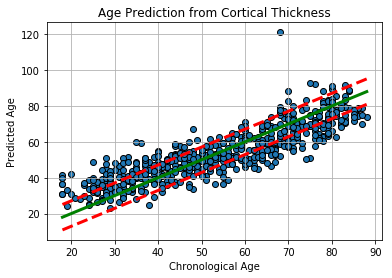

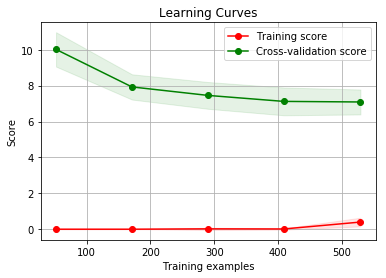

In [8]:
df_pred, arr_mae, arr_r2, train_sizes, train_scores, test_scores \
    = run_ridge(thickness_data, subjects_data, cv=CV, n_jobs=N_JOBS)

arr_mae = -arr_mae
mae = arr_mae.mean()
std = arr_mae.std()

print('MAE: %.2f' % mae)
print('MAE STD: %.2f' % std)

anatomy_mae['Cortical Thickness'] = arr_mae
anatomy_mae_std['Cortical Thickness'] = (mae, std)
subjects_predictions.loc[df_pred.index, 'Cortical Thickness'] = df_pred[0]

plot_pred(subjects_predictions.loc[df_pred.index].age,
          subjects_predictions.loc[df_pred.index, 'Cortical Thickness'],
          mae, title='Age Prediction from Cortical Thickness')
plot_learning_curve(train_sizes, train_scores, test_scores)

#### Volume

MAE: 6.60
MAE STD: 0.40


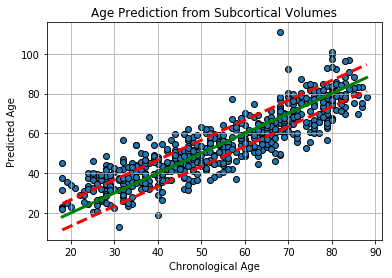

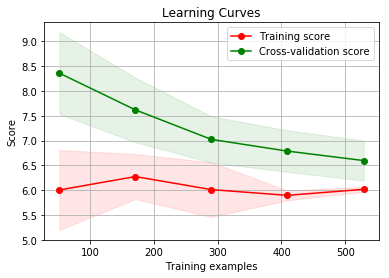

In [9]:
df_pred, arr_mae, arr_r2, train_sizes, train_scores, test_scores \
    = run_ridge(volume_data, subjects_data, cv=CV, n_jobs=N_JOBS)

arr_mae = -arr_mae
mae = arr_mae.mean()
std = arr_mae.std()

print('MAE: %.2f' % mae)
print('MAE STD: %.2f' % std)

anatomy_mae['Subcortical Volumes'] = arr_mae
anatomy_mae_std['Subcortical Volumes'] = (mae, std)
subjects_predictions.loc[df_pred.index, 'Subcortical Volumes'] = df_pred[0]

plot_pred(subjects_predictions.loc[df_pred.index].age,
          subjects_predictions.loc[df_pred.index, 'Subcortical Volumes'],
          mae, title='Age Prediction from Subcortical Volumes')
plot_learning_curve(train_sizes, train_scores, test_scores)

## Functional MRI

### BASC 197

#### Tangent Space

MAE: 5.57
MAE STD: 0.45


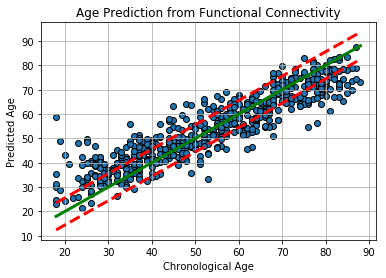

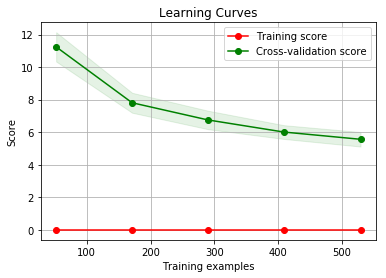

In [10]:
df_pred, arr_mae, arr_r2, train_sizes, train_scores, test_scores \
    = run_ridge(connect_data_tangent_basc, subjects_data, cv=CV, n_jobs=N_JOBS)

arr_mae = -arr_mae
mae = arr_mae.mean()
std = arr_mae.std()

print('MAE: %.2f' % mae)
print('MAE STD: %.2f' % std)

function_mae_std['Connectivity Matrix, BASC 197 tan'] = (mae, std)
function_mae['Connectivity Matrix, BASC 197 tan'] = arr_mae
subjects_predictions.loc[df_pred.index, 'Connectivity Matrix, BASC 197 tan'] = df_pred[0]

plot_pred(subjects_predictions.loc[df_pred.index].age,
          subjects_predictions.loc[df_pred.index, 'Connectivity Matrix, BASC 197 tan'],
          mae, title='Age Prediction from Functional Connectivity')
plot_learning_curve(train_sizes, train_scores, test_scores)

#### Connectivity with Fisher's r-to-z Transform

MAE: 6.40
MAE STD: 0.70


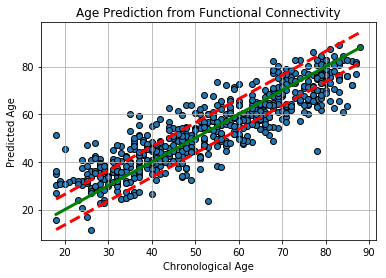

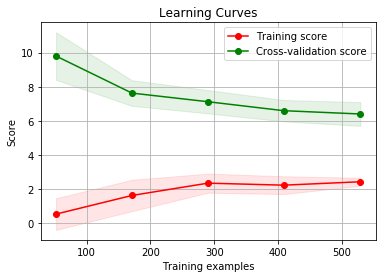

In [11]:
df_pred, arr_mae, arr_r2, train_sizes, train_scores, test_scores \
    = run_ridge(connect_data_r2z_basc, subjects_data, cv=CV, n_jobs=N_JOBS)

arr_mae = -arr_mae
mae = arr_mae.mean()
std = arr_mae.std()

print('MAE: %.2f' % mae)
print('MAE STD: %.2f' % std)

function_mae_std['Connectivity Matrix, BASC 197 r2z'] = (mae, std)
function_mae['Connectivity Matrix, BASC 197 r2z'] = arr_mae
subjects_predictions.loc[df_pred.index, 'Connectivity Matrix, BASC 197 r2z'] = df_pred[0]

plot_pred(subjects_predictions.loc[df_pred.index].age,
          subjects_predictions.loc[df_pred.index, 'Connectivity Matrix, BASC 197 r2z'],
          mae, title='Age Prediction from Functional Connectivity')
plot_learning_curve(train_sizes, train_scores, test_scores)

### MODL 256

#### Tangent Space

MAE: 5.71
MAE STD: 0.55


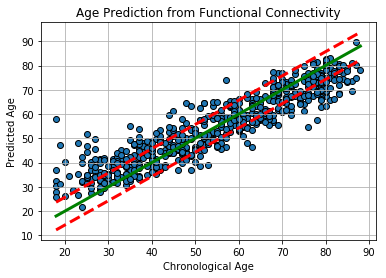

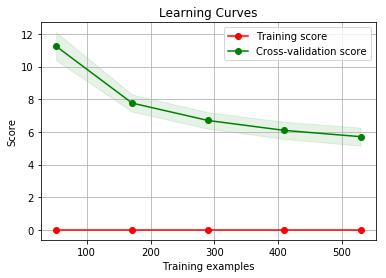

In [12]:
df_pred, arr_mae, arr_r2, train_sizes, train_scores, test_scores \
    = run_ridge(connect_data_tangent_modl, subjects_data, cv=CV, n_jobs=N_JOBS)

arr_mae = -arr_mae
mae = arr_mae.mean()
std = arr_mae.std()

print('MAE: %.2f' % mae)
print('MAE STD: %.2f' % std)

function_mae_std['Connectivity Matrix, MODL 256 tan'] = (mae, std)
function_mae['Connectivity Matrix, MODL 256 tan'] = arr_mae
subjects_predictions.loc[df_pred.index, 'Connectivity Matrix, MODL 256 tan'] = df_pred[0]

plot_pred(subjects_predictions.loc[df_pred.index].age,
          subjects_predictions.loc[df_pred.index, 'Connectivity Matrix, MODL 256 tan'],
          mae, title='Age Prediction from Functional Connectivity')
plot_learning_curve(train_sizes, train_scores, test_scores)

#### Connectivity with Fisher's r-to-z Transform

MAE: 5.71
MAE STD: 0.68


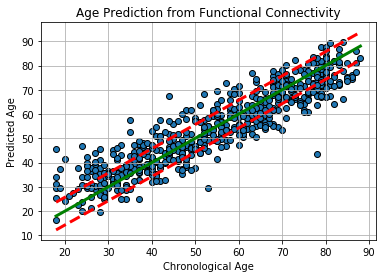

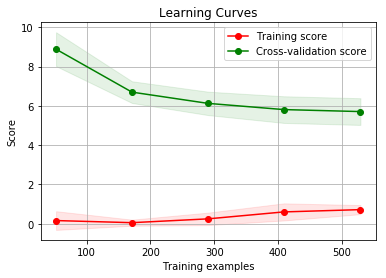

In [13]:
df_pred, arr_mae, arr_r2, train_sizes, train_scores, test_scores \
    = run_ridge(connect_data_r2z_modl, subjects_data, cv=CV, n_jobs=N_JOBS)

arr_mae = -arr_mae
mae = arr_mae.mean()
std = arr_mae.std()

print('MAE: %.2f' % mae)
print('MAE STD: %.2f' % std)

function_mae_std['Connectivity Matrix, MODL 256 r2z'] = (mae, std)
function_mae['Connectivity Matrix, MODL 256 r2z'] = arr_mae
subjects_predictions.loc[df_pred.index, 'Connectivity Matrix, MODL 256 r2z'] = df_pred[0]

plot_pred(subjects_predictions.loc[df_pred.index].age,
          subjects_predictions.loc[df_pred.index, 'Connectivity Matrix, MODL 256 r2z'],
          mae, title='Age Prediction from Functional Connectivity')
plot_learning_curve(train_sizes, train_scores, test_scores)

## MEG

In [14]:
FREQ_BANDS = [(0.1, 1.5),  # low
              (1.5, 4.0),  # delta
              (4.0, 8.0),  # theta
              (8.0, 15.0),  # alpha
              (15.0, 26.0),  # beta_low
              (26.0, 35.0),  # beta_high
              (35.0, 50.0),  # gamma_low
              (50.0, 74.0),  # gamma_mid
              (76.0, 120.0)]  # gamma_high

Opening raw data file /home/parietal/okozynet/mne_data/MNE-sample-data/MEG/sample/sample_audvis_filt-0-40_raw.fif...
    Read a total of 4 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
        Average EEG reference (1 x 60)  idle
    Range : 6450 ... 48149 =     42.956 ...   320.665 secs
Ready.
Current compensation grade : 0
MAE: 9.22
MAE STD: 0.53


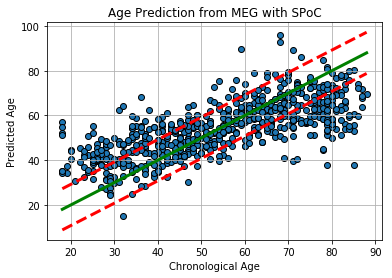

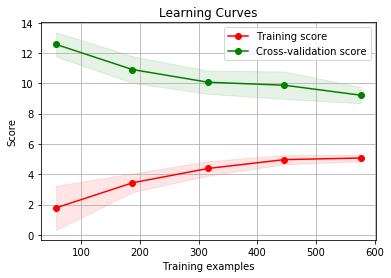

In [15]:
df_pred, arr_mae, arr_r2, train_sizes, train_scores, test_scores = \
    run_meg_ridge(meg_data, subjects_data, cv=CV, fbands=FREQ_BANDS)

arr_mae = -arr_mae
mae = arr_mae.mean()
std = arr_mae.std()

print('MAE: %.2f' % mae)
print('MAE STD: %.2f' % std)

meg_mae['MEG'] = arr_mae
meg_mae_std['MEG'] = (mae, std)
subjects_predictions.loc[df_pred.index, 'MEG'] = df_pred[0]

plot_pred(subjects_predictions.loc[df_pred.index].age,
          subjects_predictions.loc[df_pred.index, 'MEG'],
          mae, title='Age Prediction from MEG with SPoC')
plot_learning_curve(train_sizes, train_scores, test_scores)

## Stacking

Parameters for stacking were taken from [Liem's paper](https://github.com/fliem/LeiCA_LIFE/blob/e9d02464a9e43b97cef9c7b753d88120cfbd6c94/learning/learning_stacking_utils.py#L30)

### Anatomy

MAE: 5.98
MAE STD: 0.55


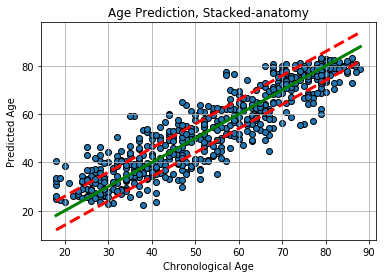

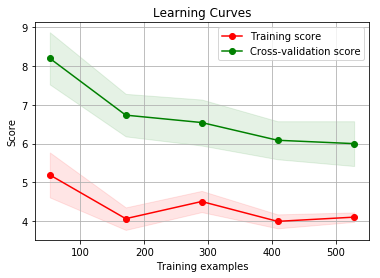

In [16]:
anatomy_data = [('area', area_data), ('thickness', thickness_data), ('volume', volume_data)]

df_pred, arr_mae, arr_r2, train_sizes, train_scores, test_scores \
    = run_stacking(anatomy_data, subjects_data, cv=CV)

arr_mae = -arr_mae
mae = arr_mae.mean()
std = arr_mae.std()

print('MAE: %.2f' % mae)
print('MAE STD: %.2f' % std)

anatomy_mae_std['Stacked-anatomy'] = (mae, std)
anatomy_mae['Stacked-anatomy'] = arr_mae
subjects_predictions.loc[df_pred.index, 'Stacked-anatomy'] = df_pred[0]

plot_pred(subjects_predictions.loc[df_pred.index].age,
          subjects_predictions.loc[df_pred.index, 'Stacked-anatomy'],
          mae, title='Age Prediction, Stacked-anatomy')
plot_learning_curve(train_sizes, train_scores, test_scores)

### Connectivity

MAE: 6.08
MAE STD: 0.77


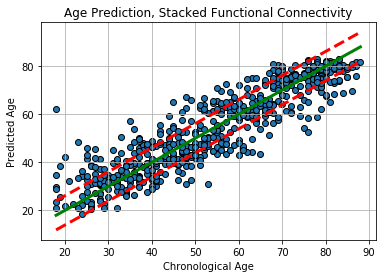

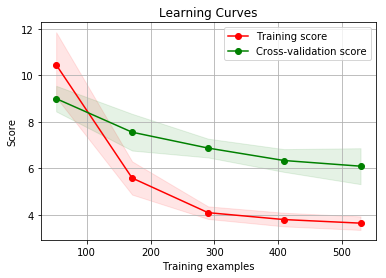

In [17]:
connect_data_tanh = [('basc', connect_data_tangent_basc), ('modl', connect_data_tangent_modl)]

df_pred, arr_mae, arr_r2, train_sizes, train_scores, test_scores \
    = run_stacking(connect_data_tanh, subjects_data, cv=CV)

arr_mae = -arr_mae
mae = arr_mae.mean()
std = arr_mae.std()

print('MAE: %.2f' % mae)
print('MAE STD: %.2f' % std)

function_mae_std['Stacked-function'] = (mae, std)
function_mae['Stacked-function'] = arr_mae
subjects_predictions.loc[df_pred.index, 'Stacked-function'] = df_pred[0]

plot_pred(subjects_predictions.loc[df_pred.index].age,
          subjects_predictions.loc[df_pred.index, 'Stacked-function'],
          mae, title='Age Prediction, Stacked Functional Connectivity')
plot_learning_curve(train_sizes, train_scores, test_scores)

### MRI Multi-modal 

MAE: 5.12
MAE STD: 0.64


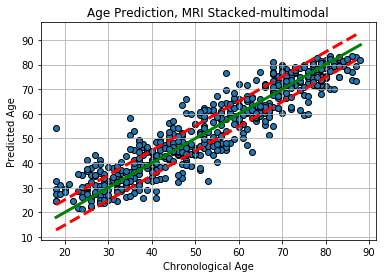

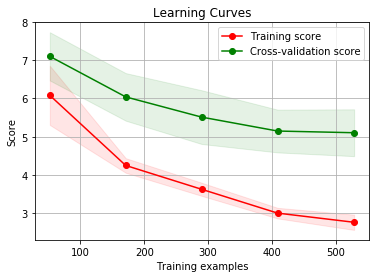

In [18]:
multimodal_data = [('area', area_data), ('thickness', thickness_data), ('volume', volume_data),
                   ('basc', connect_data_tangent_basc), ('modl', connect_data_tangent_modl)]

df_pred, arr_mae, arr_r2, train_sizes, train_scores, test_scores \
    = run_stacking(multimodal_data, subjects_data, cv=CV)

arr_mae = -arr_mae
mae = arr_mae.mean()
std = arr_mae.std()

print('MAE: %.2f' % mae)
print('MAE STD: %.2f' % std)

multimodal_mae_std['MRI Stacked-multimodal'] = (mae, std)
multimodal_mae['MRI Stacked-multimodal'] = arr_mae
subjects_predictions.loc[df_pred.index, 'MRI Stacked-multimodal'] = df_pred[0]

plot_pred(subjects_predictions.loc[df_pred.index].age,
          subjects_predictions.loc[df_pred.index, 'MRI Stacked-multimodal'],
          mae, title='Age Prediction, MRI Stacked-multimodal')
plot_learning_curve(train_sizes, train_scores, test_scores)

### Anatomy with MEG

Opening raw data file /home/parietal/okozynet/mne_data/MNE-sample-data/MEG/sample/sample_audvis_filt-0-40_raw.fif...
    Read a total of 4 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
        Average EEG reference (1 x 60)  idle
    Range : 6450 ... 48149 =     42.956 ...   320.665 secs
Ready.
Current compensation grade : 0
MAE: 5.51
MAE STD: 0.46


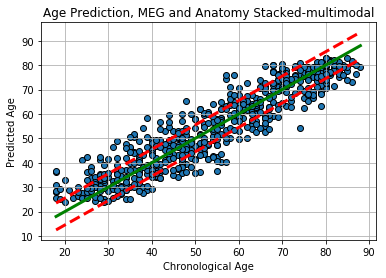

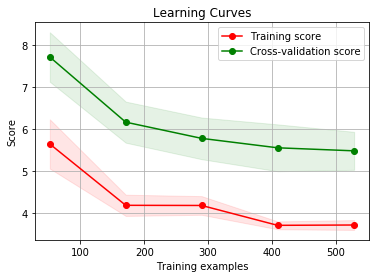

In [ ]:
multimodal_data = [('area', area_data), ('thickness', thickness_data), ('volume', volume_data),
                   ('meg', meg_data)]

df_pred, arr_mae, arr_r2, train_sizes, train_scores, test_scores \
    = run_stacking(multimodal_data, subjects_data, cv=CV, fbands=FREQ_BANDS)

arr_mae = -arr_mae
mae = arr_mae.mean()
std = arr_mae.std()

print('MAE: %.2f' % mae)
print('MAE STD: %.2f' % std)

multimodal_mae_std['MEG and Anatomy Stacked-multimodal'] = (mae, std)
multimodal_mae['MEG and Anatomy Stacked-multimodal'] = arr_mae
subjects_predictions.loc[df_pred.index, 'MEG and Anatomy Stacked-multimodal'] = df_pred[0]

plot_pred(subjects_predictions.loc[df_pred.index].age,
          subjects_predictions.loc[df_pred.index, 'MEG and Anatomy Stacked-multimodal'],
          mae, title='Age Prediction, MEG and Anatomy Stacked-multimodal')
plot_learning_curve(train_sizes, train_scores, test_scores)

### Functional with MEG

Opening raw data file /home/parietal/okozynet/mne_data/MNE-sample-data/MEG/sample/sample_audvis_filt-0-40_raw.fif...
    Read a total of 4 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
        Average EEG reference (1 x 60)  idle
    Range : 6450 ... 48149 =     42.956 ...   320.665 secs
Ready.
Current compensation grade : 0
MAE: 5.42
MAE STD: 0.49


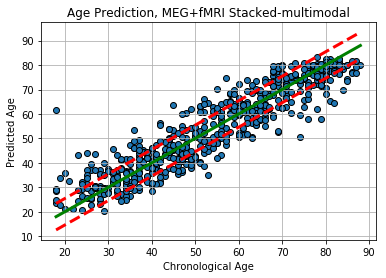

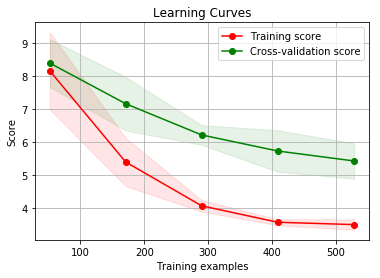

In [ ]:
multimodal_data = [('basc', connect_data_tangent_basc), ('modl', connect_data_tangent_modl),
                   ('meg', meg_data)]

df_pred, arr_mae, arr_r2, train_sizes, train_scores, test_scores \
    = run_stacking(multimodal_data, subjects_data, cv=CV, fbands=FREQ_BANDS)

arr_mae = -arr_mae
mae = arr_mae.mean()
std = arr_mae.std()

print('MAE: %.2f' % mae)
print('MAE STD: %.2f' % std)

multimodal_mae_std['MEG+fMRI Stacked-multimodal'] = (mae, std)
multimodal_mae['MEG+fMRI Stacked-multimodal'] = arr_mae
subjects_predictions.loc[df_pred.index, 'MEG+fMRI Stacked-multimodal'] = df_pred[0]

plot_pred(subjects_predictions.loc[df_pred.index].age,
          subjects_predictions.loc[df_pred.index, 'MEG+fMRI Stacked-multimodal'],
          mae, title='Age Prediction, MEG+fMRI Stacked-multimodal')
plot_learning_curve(train_sizes, train_scores, test_scores)

### MEG with MRI Multi-modal

In [ ]:
multimodal_data = [('area', area_data), ('thickness', thickness_data), ('volume', volume_data),
                   ('basc', connect_data_tangent_basc), ('modl', connect_data_tangent_modl),
                   ('meg', meg_data)]

df_pred, arr_mae, arr_r2, train_sizes, train_scores, test_scores \
    = run_stacking(multimodal_data, subjects_data, cv=CV, fbands=FREQ_BANDS)

arr_mae = -arr_mae
mae = arr_mae.mean()
std = arr_mae.std()

print('MAE: %.2f' % mae)
print('MAE STD: %.2f' % std)

multimodal_mae_std['MEG+MRI Stacked-multimodal'] = (mae, std)
multimodal_mae['MEG+MRI Stacked-multimodal'] = arr_mae
subjects_predictions.loc[df_pred.index, 'MEG+MRI Stacked-multimodal'] = df_pred[0]

plot_pred(subjects_predictions.loc[df_pred.index].age,
          subjects_predictions.loc[df_pred.index, 'MEG+MRI Stacked-multimodal'],
          mae, title='Age Prediction, MEG+MRI Stacked-multimodal')
plot_learning_curve(train_sizes, train_scores, test_scores)

Opening raw data file /home/parietal/okozynet/mne_data/MNE-sample-data/MEG/sample/sample_audvis_filt-0-40_raw.fif...
    Read a total of 4 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
        Average EEG reference (1 x 60)  idle
    Range : 6450 ... 48149 =     42.956 ...   320.665 secs
Ready.
Current compensation grade : 0


## Summary

### Results from Liem2016

In [ ]:
anatomy_mae_std_liem = {'Cortical Thickness': (5.95, 4.69),
                        'Cortical Surface Area': (7.29, 5.96),
                        'Subcortical Volumes': (6.44, 5.02),
                        'Stacked-anatomy': (4.83, 4.01)}

connect_mae_std_liem = {'Connectivity Matrix 197': (5.99, 4.57),
                        'Connectivity Matrix 444': (5.77, 4.42),
                        'Stacked-function': (5.25, 4.4)}

multimodal_mae_std_liem = {'Stacked-multimodal': (4.29, 3.49)}

plot_barchart(anatomy_mae_std_liem, title='Age Prediction, Anatomy', bar_text_indent=1)
plot_barchart(connect_mae_std_liem, title='Age Prediction, Function', bar_text_indent=1)
plot_barchart(multimodal_mae_std_liem, title='Age Prediction, Multimodal', bar_text_indent=1)

### Results for CamCAN

In [ ]:
plot_barchart(anatomy_mae_std, title='Age Prediction, Anatomy', bar_text_indent=1)
plot_barchart(function_mae_std, title='Age Prediction, Function', bar_text_indent=1)
plot_barchart(meg_mae_std, title='Age Prediction, MEG', bar_text_indent=1)
plot_barchart(multimodal_mae_std, title='Age Prediction, Multimodal', bar_text_indent=1)

In [ ]:
plot_error_age(subjects_predictions, ylim=(-2, 55))

In [ ]:
# drop results of stacked predictions
cols2drop = [c for c in subjects_predictions.columns if 'Stack' in c]
plot_error_scatters(subjects_predictions.drop(cols2drop, axis=1), xlim=(0, 55), ylim=(0, 55))

In [ ]:
plot_error_segments(subjects_predictions, segment_len=10)

In [ ]:
plot_boxplot(anatomy_mae, title='Age Prediction, Anatomy')
plot_boxplot(function_mae, title='Age Prediction, Function')
plot_boxplot(meg_mae, title='Age Prediciton, MEG')
plot_boxplot(multimodal_mae, title='Age Prediction, Multimodal')

In [ ]:
from collections import OrderedDict
from itertools import chain

it_chain = chain(anatomy_mae.items(), function_mae.items(), multimodal_mae.items(), meg_mae.items())

all_mae = OrderedDict((key, value) for key, value in it_chain if 'Stacked' not in key)

all_mae['Stacked-anatomy'] = anatomy_mae['Stacked-anatomy']
all_mae['Stacked-function'] = function_mae['Stacked-function']
all_mae['MRI and Anatomy Stacked-multimodal'] = multimodal_mae['MRI and Anatomy Stacked-multimodal']
all_mae['MEG+fMRI Stacked-multimodal'] = multimodal_mae['MEG+fMRI Stacked-multimodal']
all_mae['MRI Stacked-multimodal'] = multimodal_mae['MRI Stacked-multimodal']
all_mae['MEG+MRI Stacked-multimodal'] = multimodal_mae['MEG+MRI Stacked-multimodal']

plot_boxplot(all_mae, title='Age Prediction, Combined')

In [ ]:
# dill.dump_session('../../data/ridgecv_azzaro.db')
# dill.load_session('../../data/ridgecv_azzaro.db')